# Importing packages

In [10]:
# Importing, cleaning and visualization
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# Model Validation
from sklearn.model_selection import train_test_split,StratifiedKFold
# Imputation
from sklearn.impute import KNNImputer
# Model Evaluation
from sklearn.metrics import confusion_matrix,plot_roc_curve,accuracy_score,recall_score, precision_score,plot_confusion_matrix,f1_score
from sklearn.model_selection import cross_val_score
# Modelling
from sklearn.ensemble import RandomForestClassifier
# Balancing
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
# Scaling data
from sklearn.preprocessing import StandardScaler
# Model tuning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# Feature selection
from boruta import BorutaPy
# To avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

In [11]:
pip install boruta

Note: you may need to restart the kernel to use updated packages.


# Functions

In [12]:
# Function to remove missing values above a given threshold
def missing_remove(dataframe, threshold):
    """
    Function to remove columns with missing data that exceed the set percentage threshold limit
    
    Required arguments - 
    dataframe - Dataframe for processing (type-Pandas Dataframe)
    threshold - threshold above which columns will be removed (type-float)
    
    Optional arguments - None
    
    Expected output - Message with threshold value and number of columns removed
                      Pandas Dataframe that does not contain columns with more missing values than the threshold value
    
    """
    columns = dataframe.columns[(dataframe.isna().sum()/dataframe.shape[1])>threshold].tolist()
    print(f"# Features deleted with more than {threshold} % missing values", len(columns))
    return dataframe.drop(columns, axis=1,inplace=True)

In [13]:
def replace_outlier(val, mean, std):
    """
    Function to check if a number is greater than (mean +/- 3*standard deviation) 
    and replace that number with (mean +/- 3*standard deviation)
    
    Required arguments - 
    val - any value - float
    mean - mean of values -float
    std - standard deviation of values - float
        
    Optional arguments - None
    
    Expected output - If value is lower than mean+3*standard deviation and higher than mean-3*standard deviation
                      then return value 
                      If value is higher than mean+3*standard deviation and lower than mean-3*standard deviation 
                      then return mean+/-3*standard deviation    
    """
    if val > mean + 3*std:
        return mean + 3*std 
    elif val < mean - 3*std:
        return mean - 3*std
    return val

In [14]:
def evaluate(model, X_train,X_test,y_train,y_test):
    """
    Function to scale data, fit any model to the training dataset and evaluate that model with test dataset using confusion matrix, 
    AUC, F1 Score, Sensitivity, Recall and Precision
    
    Required arguments - 
    model - Name of the model including model parameters
    X_train - training dataset without the target variable
    X_test - test dataset without the target variable
    y_train - training dataset of the target variable
    y_test - validatation data
    
    Optional arguments - None
    
    Expected output - Output message - model name and parameters, Testing Accuracy, F1 score, Sensitivity, Recall, Precision
                      Plot of Confusion Matrix and AUC
    
    """
    #Fitting the model
    model.fit(X_train, y_train)
    
    # Scaling the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_std = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    #Predicting target variable for test data
    y_pred = model.predict(X_test)
    
    # Model metrics for evaluation
    figure(figsize=(8, 5), dpi=80)
    cm=confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d",cmap="YlOrRd",yticklabels = ['Act. Pass', 'Act. Fail'], xticklabels = ['Pred. Pass' , 'Pred. Fail'])
    ax = plt.gca()
    plot = plot_roc_curve(model, X_test, y_test, ax=ax, alpha=0.8)
    print("Model Name:", model)
    f1score = f1_score(y_test, y_pred, average='micro')
    sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
    recall = recall_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    print("F1 Score:", f1score) 
    print("Sensitivity:" , sensitivity)
    print("Recall:" , recall)
    print("Precision:" , precision)

In [15]:
def BorutaFeatureSelection (X_train, y_train) :
    """
    Function to find the best features using Boruta along with the feature scores. Only features with Rank 1 will 
    be selected and tentative features will be ignored.
    
    Required arguments - 
    X_train - training dataset without the target variable
    y_train - training dataset of the target variable
    
    Optional arguments - None
    
    Expected output - Output message - Feature ranking and whether that feature will be kept or removed
                                     - Final features
                      Pandas Dataframe that contains only final features selected using Boruta
    """
    feature_names = np.array(X_train.columns)

    model =RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=6,class_weight='balanced_subsample')
    model.fit(X_train, y_train)
    
    feature_selector = BorutaPy(model, random_state=2, verbose=2,max_iter=455,n_estimators=200)

    feature_selector.fit(X_train.to_numpy(),y_train)

    feature_selector.support_

    feature_selector.ranking_

    feature_ranks = list(zip(feature_names, 
                             feature_selector.ranking_, 
                             feature_selector.support_))

    for feat in feature_ranks:
        print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features = list()
    indexes = np.where(feature_selector.ranking_ <= 1)
    for x in np.nditer(indexes):
        final_features.append(feature_names[x])
    print(final_features)
    return pd.DataFrame(X_train.filter(final_features)) , final_features

In [16]:
def Sampling(X_train, y_train, sampler):
    """
    Function to apply any balancing method to a dataframe
    
    Required arguments - 
    X_train - training dataset without the target variable (pandas dataframe)
    y_train - training dataset of the target variable (pandas dataframe)
    sampler - Name of balancing method (string)
    
    Optional arguments - None
    
    Expected output - Pandas Dataframe with balanced data

    """
    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    
    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
        
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)
        
    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    

    #SMOTTEENN
    if sampler == 'SMOTEENN' :
        sampler = SMOTEENN(random_state=100)
    
     # SMOTETOMEK
    
    if sampler == 'SMOTETOMEK' :
        sampler = SMOTETomek(random_state=100)
        
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

# Importing and basic cleaning

In [17]:
# Importing data from internet in runtime
data_url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"

In [18]:
# Assigning data to a Pandas Dataframe
secom_data = pd.read_csv(data_url,sep=' ',header=None)

In [19]:
# Renaming the column's headers 
secom_data.columns = ["Feature_"+str(column+1) for column in range(len(secom_data.columns))]
secom_data.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_581,Feature_582,Feature_583,Feature_584,Feature_585,Feature_586,Feature_587,Feature_588,Feature_589,Feature_590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [20]:
# Importing target data from internet in runtime
label_url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

In [21]:
# Assigning target data to a pandas dataframe
secom_labels = pd.read_csv(label_url, sep = " ",header=None)

In [22]:
# Renaming the column's headers 
secom_labels.columns = ["Classification","Timestamp"]

In [23]:
# Changing datatype for consistency
secom_labels['Timestamp'] = pd.to_datetime(secom_labels['Timestamp'],errors='raise')

In [24]:
# Merging data
data= pd.concat([secom_labels,secom_data],axis=1)

In [25]:
# Dropping the Timestamp column as it provides no insight
data.drop(columns="Timestamp", errors='raise',inplace=True)

In [26]:
# Using the Classification column as the target variable
target = data[['Classification']]
data.drop(['Classification'], axis=1,inplace=True)

# Splitting dataset into training and test dataset

#### We split the data into training and test datasets with a ratio of 80:20. Since the dataset is not large enough, we use 80% of the data for training the model. We will train the model using the training dataset and evaluate the model using the test dataset

#### Because the data is imbalanced between pass and fail, we use the "stratify" parameter to ensure the same ratio of pass and fail is retained when splitting the dataset. The "random_state" parameter also helps to create reproducible data.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data,target, test_size=0.20, random_state=42, stratify=target)

# Removing columns with more than 50% of missing values

In [28]:
X_train_missing = X_train
missing_remove(X_train_missing, 0.5)
X_train_missing.shape

# Features deleted with more than 0.5 % missing values 32


(1253, 558)

In [29]:
# Deleting the same columns that are removed in training set from the test set
X_test_missing = X_test[np.array(X_train_missing.columns)]
X_test_missing.shape

(314, 558)

# Replacing outliers with 3s boundary

In [30]:
#Replacing the outliers with 3s boundaries in X_train 
for col in X_train_missing.columns:
    mean = X_train_missing[col].mean()
    std_dev = X_train_missing[col].std(axis=0)
    X_train_missing[col] = X_train_missing[col].map(lambda x: replace_outlier(x, mean, std_dev))

In [31]:
#Replacing the outliers with 3s boundaries in X_test
for col in X_test_missing.columns:
    mean = X_test_missing[col].mean()
    std_dev = X_test_missing[col].std(axis=0)
    X_test_missing[col] = X_test_missing[col].map(lambda x: replace_outlier(x, mean, std_dev))

# Imputing the missing values with KNN

In [32]:
knn = KNNImputer()
knn.fit(X_train_missing)
X_train_knn=pd.DataFrame(knn.transform(X_train_missing), columns=X_train_missing.columns)
X_train_knn.isna().sum().sum()

0

In [33]:
knn.fit(X_test_missing)
X_test_knn=pd.DataFrame(knn.transform(X_test_missing), columns=X_test_missing.columns)
X_test_knn.isna().sum().sum()

0

# Feature Selection using Boruta

In [34]:
X_train_boruta , final_features = BorutaFeatureSelection(X_train_knn,y_train.values.ravel())

Iteration: 	1 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	2 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	3 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	4 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	5 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	6 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	7 / 455
Confirmed: 	0
Tentative: 	558
Rejected: 	0
Iteration: 	8 / 455
Confirmed: 	0
Tentative: 	27
Rejected: 	531
Iteration: 	9 / 455
Confirmed: 	2
Tentative: 	25
Rejected: 	531
Iteration: 	10 / 455
Confirmed: 	2
Tentative: 	25
Rejected: 	531
Iteration: 	11 / 455
Confirmed: 	2
Tentative: 	25
Rejected: 	531
Iteration: 	12 / 455
Confirmed: 	6
Tentative: 	18
Rejected: 	534
Iteration: 	13 / 455
Confirmed: 	6
Tentative: 	18
Rejected: 	534
Iteration: 	14 / 455
Confirmed: 	6
Tentative: 	18
Rejected: 	534
Iteration: 	15 / 455
Confirmed: 	6
Tentative: 	18
Rejected: 	534
Iteration: 	16 / 455
Confirmed: 	6
Tentat

Iteration: 	127 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	128 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	129 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	130 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	131 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	132 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	133 / 455
Confirmed: 	18
Tentative: 	4
Rejected: 	536
Iteration: 	134 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	135 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	136 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	137 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	138 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	139 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	140 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	141 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration:

Iteration: 	252 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	253 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	254 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	255 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	256 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	257 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	258 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	259 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	260 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	261 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	262 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	263 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	264 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	265 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	266 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration:

Iteration: 	377 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	378 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	379 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	380 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	381 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	382 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	383 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	384 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	385 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	386 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	387 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	388 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	389 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	390 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration: 	391 / 455
Confirmed: 	19
Tentative: 	3
Rejected: 	536
Iteration:

In [35]:
# Deleting the same columns that are removed in training set from the test set
X_test_boruta = X_test_knn[np.array(X_train_boruta.columns)]
X_test_boruta.shape

(314, 20)

### Checking the correlation between variables

Text(0.5, 1.0, 'Heatmap for the Data')

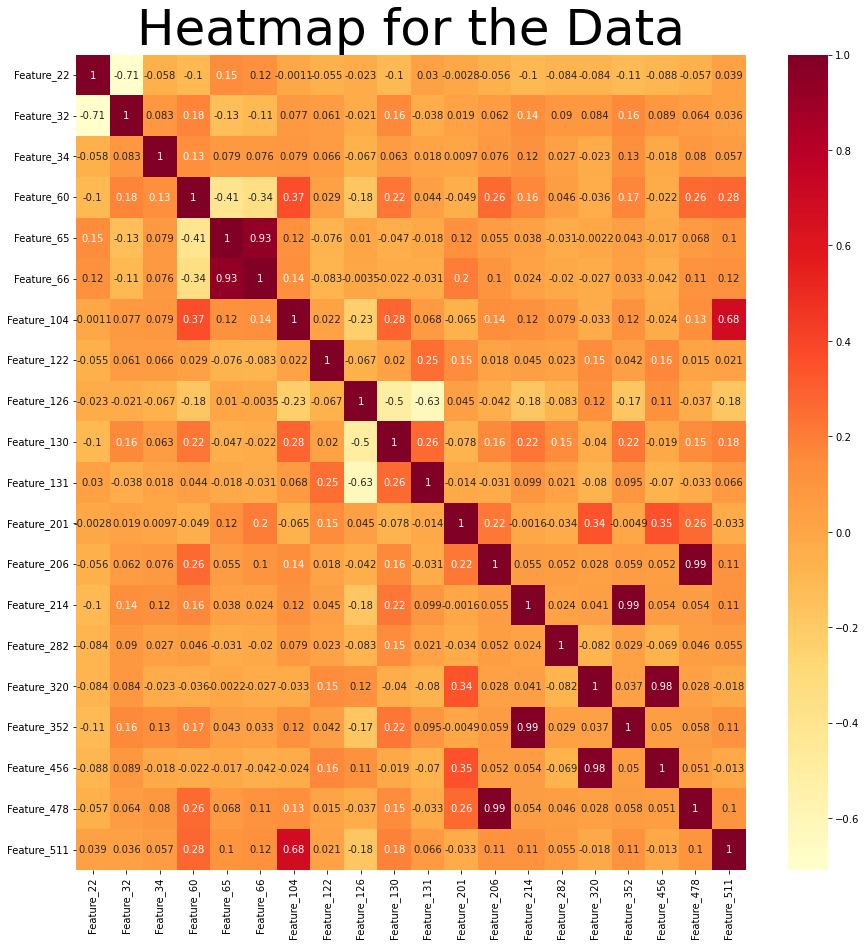

In [36]:
# Correlation Heatmap
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(X_train_boruta.corr(),cmap="YlOrRd",annot=True)
plt.title('Heatmap for the Data', fontsize = 50)

### Analysing the best featues

Text(0.5, 0, 'Feature Importance')

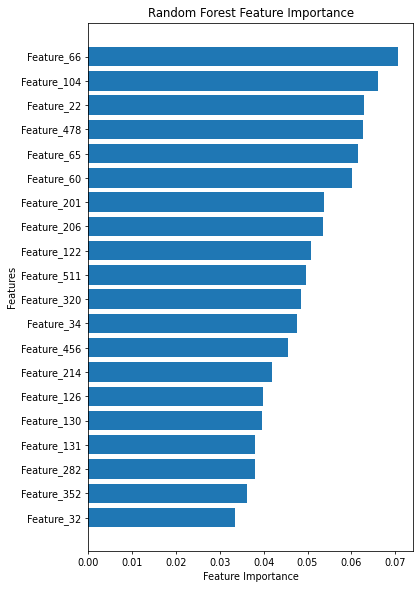

In [37]:
# Analysing Feature Importance using Random Forest Classifier
model = RandomForestClassifier()
model.fit(X_train_boruta, y_train.values.ravel())
feature_selector = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=6, random_state=100)
figure(figsize=(6, 10), dpi=70)
sorted_idx = model.feature_importances_.argsort()
plt.barh(X_train_boruta.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.title('Random Forest Feature Importance')
plt.ylabel('Features')
plt.xlabel("Feature Importance")

# Balancing the data using ROSE

In [42]:
from imblearn.combine import SMOTETomek 
from imblearn.combine import SMOTEENN


In [43]:
# Balancing the data using Random Over-Sampling Examples (ROSE)
X_rose, y_rose = Sampling(X_train_boruta, y_train,'ROSE')

In [44]:
X_smote, y_smote = Sampling(X_train_boruta, y_train,'SMOTE')

In [45]:
X_adasyn, y_adasyn = Sampling(X_train_boruta, y_train,'ADASYN')

In [46]:
X_smoteenn, y_smoteenn = Sampling(X_train_boruta, y_train,'SMOTEENN')

In [47]:
X_smotetomek, y_smotetomek = Sampling(X_train_boruta, y_train,'SMOTETOMEK')

# Scaling data and fitting model
# - Random Forest Classifier

Model Name: RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       n_jobs=-1, random_state=100)
F1 Score: 0.8662420382165607
Sensitivity: 0.9630996309963099
Recall: 0.5238095238095238
Precision: 0.2558139534883721


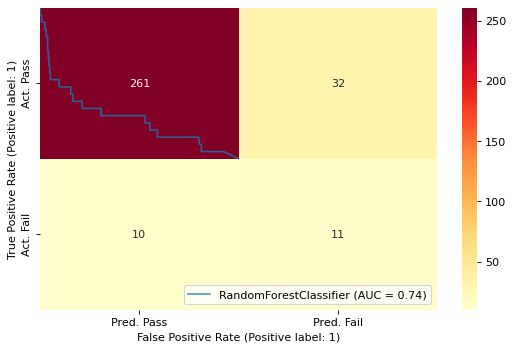

In [48]:
evaluate(RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=6, random_state=100),X_rose,X_test_boruta,y_rose,y_test)

Model Name: RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       n_jobs=-1, random_state=100)
F1 Score: 0.7961783439490446
Sensitivity: 0.9455252918287937
Recall: 0.3333333333333333
Precision: 0.12280701754385964


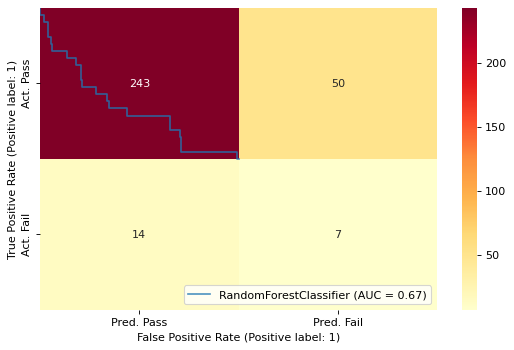

In [49]:
evaluate(RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=6, random_state=100),X_smote,X_test_boruta,y_smote,y_test)

Model Name: RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       n_jobs=-1, random_state=100)
F1 Score: 0.8439490445859873
Sensitivity: 0.9485294117647058
Recall: 0.3333333333333333
Precision: 0.16666666666666666


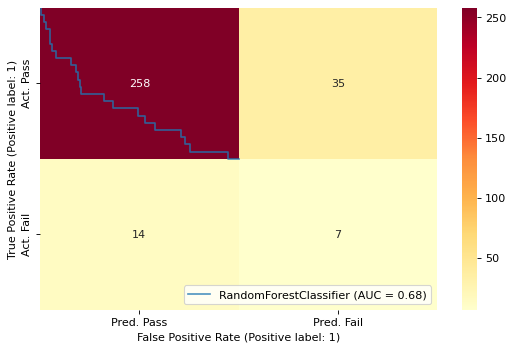

In [50]:
evaluate(RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=6, random_state=100),X_adasyn,X_test_boruta,y_adasyn,y_test)

Model Name: RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       n_jobs=-1, random_state=100)
F1 Score: 0.8057324840764332
Sensitivity: 0.9496124031007752
Recall: 0.38095238095238093
Precision: 0.14285714285714285


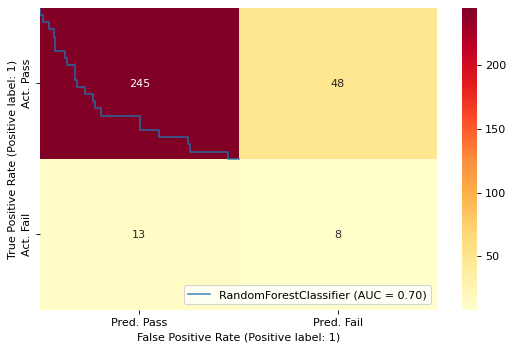

In [51]:
evaluate(RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=6, random_state=100),X_smoteenn,X_test_boruta,y_smoteenn,y_test)

Model Name: RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       n_jobs=-1, random_state=100)
F1 Score: 0.821656050955414
Sensitivity: 0.9438202247191011
Recall: 0.2857142857142857
Precision: 0.1276595744680851


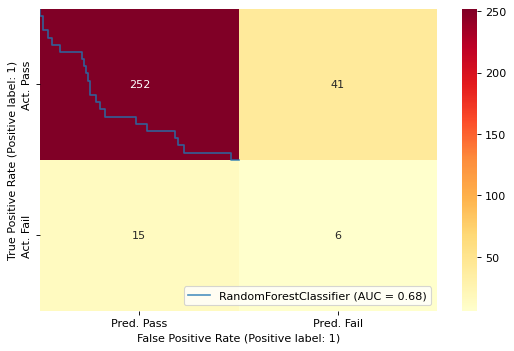

In [52]:
evaluate(RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=6, random_state=100),X_smotetomek,X_test_boruta,y_smotetomek,y_test)

# Tuning the Model

In [ ]:
# Model: Random Forest Classifier

# Define the parameters needed to try
params = {'criterion' : ["gini","entropy","log_loss"],
          'max_depth':[4,5,6,7,8,9,10],
         'max_features':["sqrt","log2","auto",None]}
          
# Find the best parameters with the highest AUC
# Fit the model as per fixed and trial parameters and apply cross-validation using StratifiedKFold = 10
grid_searcher = GridSearchCV(RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1), params,scoring='roc_auc', cv = 10, verbose=1)

# Fit the model with the best parameters
grid_searcher.fit(X_rose, y_rose)

In [ ]:
# Print the best parameters and best estimator

print('\n Best estimator:')
print(grid_searcher.best_estimator_)

print('\n Best hyperparameters:')
print(grid_searcher.best_params_)

In [ ]:
# Fit the model with tuned parameters
evaluate(grid_searcher.best_estimator_,X_rose,X_test_boruta,y_rose,y_test)


# Checking if our model is overfitting

In [ ]:
# define the tree depth for evaluation 
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
test_scores=[]
train_scores=[]
for i in values:
    # configure the model
    model = RandomForestClassifier(n_estimators=100,max_features='sqrt',random_state=42,n_jobs=-1,max_depth=i,criterion='entropy')
    # fit model to the training dataset
    model.fit(X_rose, y_rose)
    # evaluate model using the training dataset
    train_yhat = model.predict(X_rose)
    train_acc = accuracy_score(y_rose, train_yhat)
    train_scores.append(train_acc)
    # evaluate model using the test dataset
    test_yhat = model.predict(X_test_boruta)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    # print the results
    print('%d train: %.3f, test: %.3f' % (i, train_acc, test_acc))

In [ ]:
# Plot the results for better visualization
figure(figsize=(8, 5), dpi=80)
# plot the scores for training and test dataset vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.title('Model Fit Analysis')
plt.xlabel('Max Depth (Random Forest)')
plt.ylabel('Accuracy Score')
plt.legend()
loc = list(range(21))
plt.xticks(loc)
plt.show()

# Final model after the best fit

In [ ]:
evaluate(RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1,max_depth=8,criterion='entropy',max_features='sqrt'),
         X_rose,X_test_boruta,y_rose,y_test)

